In [154]:
import math
import matplotlib.pyplot as plt
import random
# calculus
import sympy as sym

## Gamma Function

In [177]:
def gamma_function(z):
    t = sym.symbols('t')
    integral = (t ** (z-1)) * sym.exp(-t)
    lower_bound = 0
    upper_bound = float('inf')
    result = sym.integrate(integral, (t, lower_bound, upper_bound))
    return result

In [178]:
from scipy.special import gamma

def gamma_function_2(z):
    return gamma(z)

In [188]:
from datetime import datetime

start = datetime.now()
print(gamma_function(1.5))
end = datetime.now()

print(end-start)

0.886226925452758
0:00:00.025571


In [189]:
start = datetime.now()
print(gamma_function_2(1.5))
end = datetime.now()

print(end-start)

0.8862269254527579
0:00:00.001915


In [223]:
import time
from mpmath import mp

# Set precision
mp.dps = 50000

# Start the timer
start_time = time.time()

# Perform the computation
# (replace this with your actual computation)
result = mp.factorial(100000)

# Stop the timer
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

KeyboardInterrupt: 

## Capture probability function

In [156]:
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    result = 0
    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2) + (math.sqrt(Py / (Pr * Px)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / math.sqrt(Py / (Pr * Px)) - 1 / math.sqrt(Pr * Py / Px)) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (math.sqrt(Pr * Py / Px) - math.sqrt(Py / (Pr * Px))) / 2

    return result

In [157]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
#             Calculate capture probability
            capture_prob = 0
            if M[i] <= 0:
                M_i_s[i][n] = 0
                M_i_f[i][n] = 0
            else:
                for n1 in range(1, step+1):
                    for n2 in range(1, step+1):
                        # sta_ratio is M_i[n] / M_i
                        sta_ratio_1 = 1 / step
                        sta_ratio_2 = 1 / step
                        # P is the power of two station
                        P1 = 2 ** (n1 - 1)
                        P2 = 2 ** (n2 - 1)
                        capture_prob += P_cap(P1, P2, CR) * sta_ratio_1 * sta_ratio_2
#                 M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
                if (M_i[i][n] > 2):
                    M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                if (M_i[i][n] <= 2):
                    M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
                M_i_s_C[i] += M_i_s[i][n]
                
                avg_power = sum([2**n for n in range(step)]) / step
                counter_power += M_i_s[i][n] * avg_power * (n-1)
                # success STA have differnet power usage between captured and no-capture
                # capture power
                counter_power += 4.25 * capture_prob * M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#                 if (M_i[i][n] > 1):
#                     counter_power += 4.25 * capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M_i[i][n]+1) / (gamma_function(2+1) * gamma_function(M_i[i][n]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                # no-capture power
                counter_power += avg_power * M_i[i][n] * math.exp(-M[i] / Ri[i])
        
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # Average power usage
    counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# CR=1.5

In [159]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# # for r in R:
# for idx, r in enumerate(R):
#     for sta in range (1, sta_max+1):
#         Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=float('inf'), step=4)
#         ps_list[idx][sta-1] = Ps
#         da_list[idx][sta-1] = Da
#         u_list[idx][sta-1] = U
        
power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=1.5, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [160]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.99971249999999, 0.9913296666663265, 0.9402755000000491, 0.8198241999999659, 0.6632236666666219, 0.5173644285712965, 0.4029398750000009, 0.3178094444441588, 0.25602050000000487, 0.21092772727274792, 0.17723391666662977, 0.15212646153833856, 0.13259878571425096, 0.11714020000005804, 0.10490775000000241, 0.09486717647064272, 0.08669555555556996, 0.07969668421050162, 0.07373474999998282]
da_list_simu_9 = [10.306848225010805, 16.97274260193813, 24.482499696611686, 31.44612394525566, 37.02129895020637, 41.31151482340615, 44.84175148074347, 47.99761846987813, 50.87811164674203, 53.50590516980729, 55.90353111627117, 58.022514687916704, 59.893098593364115, 61.51457758779764, 62.90592587549901, 64.08462142047429, 65.09548438989164, 65.93882828667056, 66.67778434077182, 67.3154978259074]
t_list_simu_9 = [0.6666666666657952, 1.3329499999982566, 1.982659333332653, 2.507401333333438, 2.73274733333275, 2.6528946666664877, 2.414367333333439, 2.149012666666732, 1.9068566666666729, 1.7068033333334802, 1.5468033333334115, 1.4178713333330382, 1.3184293333326147, 1.2375886666658902, 1.171401999999351, 1.119015999999514, 1.0751613333330239, 1.0403466666665089, 1.0094913333333129, 0.9831300000000819]
u_list_simu_9 = [0.07407407407395672, 0.14810555555532146, 0.22029548148179304, 0.2786001481478704, 0.3036385925921946, 0.29476607407374494, 0.2682630370368982, 0.23877918518526672, 0.21187296296314495, 0.1896448148149174, 0.1718670370369795, 0.15754125925912055, 0.1464921481480377, 0.13750985185178335, 0.1301557777777516, 0.12433511111111904, 0.11946237037040316, 0.115594074074127, 0.11216570370376917, 0.10923666666674053]
power_list_simu_9 = [5.817003999999964, 8.228405233574188, 10.63390352387044, 12.695663521055298, 14.196684877251249, 15.218576189582974, 15.948238914264738, 16.522092815845372, 16.97796968043014, 17.36105956548017, 17.689098546475552, 17.95330823683526, 18.17784430968691, 18.356809444514823, 18.494159463545802, 18.609619422934998, 18.699320908309428, 18.75662552550957, 18.81731094473701, 18.85447528671189]


ps_list_simu_18 = [1.0, 1.0, 0.9998666666666665, 0.9970550000000168, 0.9744439999998991, 0.8998849999999771, 0.7670714285714266, 0.6207300000000006, 0.48721444444445033, 0.3828919999999984, 0.3044581818182112, 0.24624916666666521, 0.20171230769231088, 0.16876428571429036, 0.1434426666666759, 0.12389312500000049, 0.10839411764706379, 0.09624944444444694, 0.08596210526315422, 0.07788350000000709]
da_list_simu_18 = [7.322878590000054, 9.566351534999706, 12.55540833261096, 16.055020187498467, 19.744944070296945, 23.089779193637355, 25.663761156001918, 27.64741835818101, 29.329750724178126, 30.858663228050368, 32.30238831241783, 33.67893276459861, 35.007246582574545, 36.22935520825853, 37.30281655411831, 38.29523504536932, 39.25091737758454, 40.022521528166756, 40.73334860979044, 41.348417669551196]
t_list_simu_18 = [1.25, 2.5, 3.7495, 4.985275, 6.090275, 6.7491375, 6.711875, 6.2073, 5.4811625, 4.78615, 4.1863, 3.6937375, 3.277825, 2.953375, 2.68955, 2.4778625, 2.303375, 2.1656125, 2.0416, 1.9470875]
u_list_simu_18 = [0.0694444444444545, 0.138888888888909, 0.20830555555552846, 0.27695972222225895, 0.3383486111111088, 0.3749520833333313, 0.372881944444445, 0.3448499999999999, 0.30450902777777883, 0.26589722222222173, 0.23257222222222282, 0.20520763888888827, 0.18210138888888888, 0.1640763888888888, 0.14941944444444502, 0.1376590277777783, 0.12796527777777805, 0.12031180555555496, 0.11342222222222122, 0.10817152777777646]
power_list_simu_18 = [4.802870000000005, 6.121119999999998, 7.711192438423676, 9.476705533397768, 11.283408635902816, 12.85482699932606, 14.026875247079095, 14.860166276509972, 15.483043699922831, 15.99175246765423, 16.452912699650152, 16.862963342086534, 17.198817602748814, 17.543065416585975, 17.803669255627273, 18.018517543159852, 18.2123548555707, 18.399556490333, 18.504502472953238, 18.662356567675552]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 0.9999899999999999, 0.9998750000000004, 0.9985400000000114, 0.9911637500000053, 0.9627533333333685, 0.8940929999999877, 0.7829300000000001, 0.6499841666666681, 0.5182976923076873, 0.4049164285714269, 0.3122093333333677, 0.2389218750000006, 0.18335705882355285, 0.14065500000000003, 0.10841736842104809, 0.08352950000000779]
da_list_simu_37 = [6.4465135500000335, 7.315758975000019, 8.247483040000064, 9.291735787499658, 10.449781273816415, 11.77822436925249, 13.262876699970713, 14.854992012479677, 16.384419058570316, 17.568248492861276, 18.31029115118941, 18.637573112582487, 18.725152609232204, 18.650257543092817, 18.493435317377187, 18.336711456477715, 18.133267460386836, 17.991467766062573, 17.85393621801485, 17.687994975867607]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 9.9999, 11.99850000000001, 13.979560000000092, 15.858620000000085, 17.329559999999976, 17.88186000000004, 17.22445999999995, 15.599619999999925, 13.47574000000006, 11.3376599999999, 9.366280000000039, 7.645500000000019, 6.234140000000011, 5.063580000000008, 4.1198599999999965, 3.3411800000000067]
u_list_simu_37 = [0.05405405405406058, 0.10810810810812116, 0.16216216216214344, 0.21621621621624232, 0.27026756756758796, 0.32428378378374634, 0.3778259459459098, 0.42861135135138584, 0.468366486486496, 0.4832935135135168, 0.4655259459459463, 0.4216113513513478, 0.36420918918918826, 0.30642324324324555, 0.2531427027027043, 0.2066351351351318, 0.16849027027026756, 0.13685351351351527, 0.11134756756756929, 0.09030216216216194]
power_list_simu_37 = [4.2574999999999905, 4.836965000000002, 5.447026666666662, 6.1370800000000205, 6.907105377551016, 7.786283129287261, 8.76883202927627, 9.828868478118435, 10.881997752861983, 11.730781449305796, 12.308245538072804, 12.587117922403463, 12.718274294087722, 12.712766847454276, 12.661607524018692, 12.576226796625319, 12.478648316731594, 12.409405467205646, 12.314905302392726, 12.21881710090382]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999988888888889, 0.9999939999999998, 0.9999754545454541, 0.999915833333334, 0.9996684615384654, 0.998852142857156, 0.9965513333332985, 0.9913368749999598, 0.9807641176469392, 0.9626905555556081, 0.9335047368420821, 0.8933415000000064]
da_list_simu_74 = [6.054963090000243, 6.476296800000052, 6.906915320000113, 7.339528844999647, 7.808589504000089, 8.282513814999989, 8.784632395714235, 9.332467927499755, 9.87834355262182, 10.487032381025974, 11.112945042070756, 11.80941293834798, 12.527333273531362, 13.296063499157945, 14.094162058435284, 14.894967383480907, 15.678682952481998, 16.408102479075218, 17.048713269429676, 17.56449784413715]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999979999999997, 19.99988, 21.99946, 23.997979999999984, 25.991379999999893, 27.96785999999958, 29.896539999999014, 31.722779999998714, 33.345979999999116, 34.656860000000115, 35.47317999999997, 35.733659999999986]
u_list_simu_74 = [0.02702702702703029, 0.05405405405406058, 0.08108108108107172, 0.10810810810812116, 0.13513513513514533, 0.16216216216214344, 0.1891891891891683, 0.21621621621624232, 0.24324297297302563, 0.270268648648669, 0.2972900000000646, 0.32429702702698976, 0.3512348648647886, 0.37794405405401726, 0.4040072972973211, 0.42868621621626934, 0.45062135135133746, 0.4683359459459435, 0.47936729729730787, 0.48288729729730384]
power_list_simu_74 = [3.9981699999999694, 4.281264999999992, 4.5669899999999855, 4.850450000000009, 5.170629999999997, 5.478289999999995, 5.807518571428579, 6.174092500000016, 6.528531473158521, 6.929078527726217, 7.342726995026706, 7.809697444534539, 8.281930015812872, 8.791023216693493, 9.32250246336748, 9.863626724569276, 10.39114335339272, 10.89722440967856, 11.344329653037121, 11.736351845108105]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999988235294117, 0.9999983333333333, 0.9999989473684211, 0.9999965000000002]
da_list_simu_148 = [5.86264839000049, 6.076804140000199, 6.288142299999981, 6.50240678249973, 6.711124961999846, 6.923981595000114, 7.145808051428364, 7.366539416249603, 7.587996790000038, 7.826096382000009, 8.060874002727635, 8.301187439999984, 8.557100833846189, 8.801760803571057, 9.065646882000063, 9.340495222499877, 9.619554541911807, 9.90591017260366, 10.206478771236272, 10.505670850884252]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.999959999999994, 35.99994, 37.999959999999994, 39.99986]
u_list_simu_148 = [0.013513513513515145, 0.02702702702703029, 0.04054054054053586, 0.05405405405406058, 0.06756756756757266, 0.08108108108107172, 0.09459459459458415, 0.10810810810812116, 0.12162162162164798, 0.13513513513514533, 0.14864864864868102, 0.16216216216214344, 0.1756756756756369, 0.1891891891891683, 0.20270270270270863, 0.21621621621624232, 0.22972945945946363, 0.24324283783789052, 0.25675648648643135, 0.27026932432434475]
power_list_simu_148 = [3.870780000000003, 4.024700000000002, 4.1574499999999945, 4.293225000000016, 4.43407399999999, 4.575705, 4.726587142857152, 4.87072625000001, 5.023376666666687, 5.175959000000008, 5.327406363636354, 5.494763333333351, 5.658731538461541, 5.818122857142869, 5.997133333333354, 6.176319374999984, 6.359465049019616, 6.551371665794831, 6.747466388192687, 6.942021381478068]

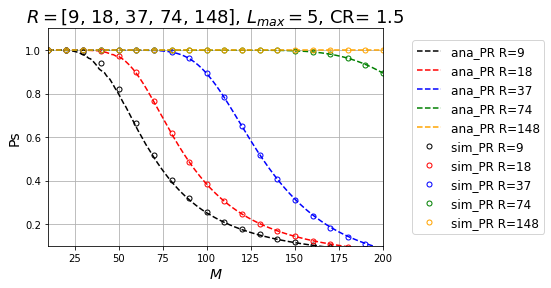

In [161]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

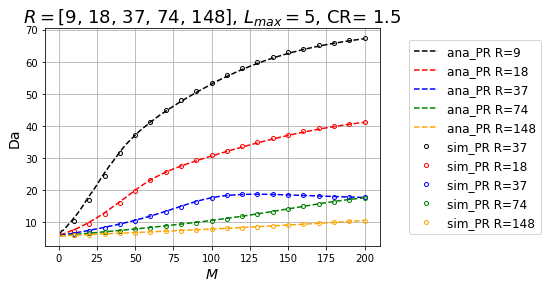

In [162]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

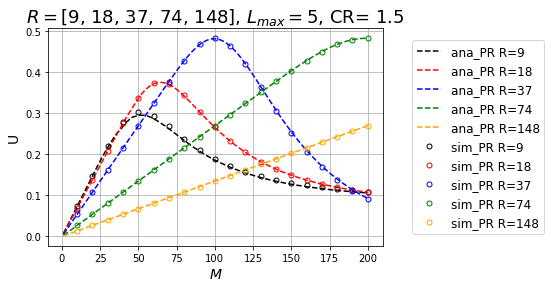

In [163]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

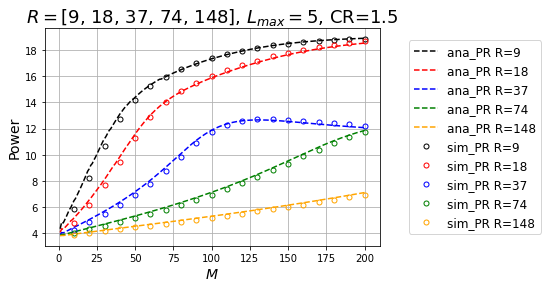

In [164]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [165]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# # for r in R:
# for idx, r in enumerate(R):
#     for sta in range (1, sta_max+1):
#         Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=float('inf'), step=4)
#         ps_list[idx][sta-1] = Ps
#         da_list[idx][sta-1] = Da
#         u_list[idx][sta-1] = U
        
power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power

In [166]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9995500000000002, 0.9875666666666669, 0.9226750000000021, 0.7854400000000002, 0.6272999999999997, 0.487685714285714, 0.37793749999999987, 0.300122222222222, 0.24209999999999973, 0.19972727272727292, 0.1666416666666668, 0.14440769230769304, 0.1258928571428571, 0.11126000000000028, 0.09956874999999993, 0.08964117647058853, 0.08237777777777784, 0.07618421052631563, 0.07044500000000006]
da_list_simu_9 = [10.666941900000024, 17.638193021052736, 25.336653394354954, 32.439351293685824, 37.807965138261146, 41.86244608001372, 45.38724778855764, 48.72269654815712, 51.33487155704903, 54.132859753338124, 56.39721567011331, 58.535817696642106, 60.26059918965681, 61.823397085734, 63.34683971681078, 64.23820612760447, 65.25560619083103, 66.19687504687988, 67.0281702646819, 67.52798169840759]
t_list_simu_9 = [0.6666666666666636, 1.3327333333333273, 1.9751333333333339, 2.4604666666666675, 2.6181333333333288, 2.509199999999999, 2.275866666666669, 2.015666666666669, 1.8007333333333275, 1.6139999999999979, 1.4646666666666666, 1.3331333333333344, 1.2515333333333365, 1.1750000000000038, 1.1126000000000003, 1.0620666666666687, 1.015933333333335, 0.9885333333333342, 0.9649999999999979, 0.9392666666666659]
u_list_simu_9 = [0.074074074074075, 0.1480814814814833, 0.21945925925926216, 0.27338518518518506, 0.2909037037037031, 0.2787999999999998, 0.25287407407407425, 0.22396296296296328, 0.20008148148148128, 0.1793333333333329, 0.16274074074074035, 0.14812592592592574, 0.13905925925925924, 0.13055555555555554, 0.12362222222222248, 0.11800740740740759, 0.11288148148148157, 0.10983703703703715, 0.10722222222222222, 0.10436296296296312]
power_list_simu_9 = [5.8759999999999994, 8.426515789473697, 10.871119959159605, 12.981163972124186, 14.391541226951738, 15.336697116665357, 16.05058368314136, 16.58083667761916, 16.99620358708064, 17.431150127497506, 17.691236547074098, 18.032808458020938, 18.119509509135067, 18.3292932552151, 18.50291909630321, 18.640635080749544, 18.65608085450822, 18.73374452092813, 18.809913509813224, 18.916858649932795]


ps_list_simu_18 = [1.0, 1.0, 0.9997666666666667, 0.9950750000000022, 0.9601000000000083, 0.8695499999999994, 0.7272571428571425, 0.5810374999999992, 0.45683333333333304, 0.35844, 0.28456363636363624, 0.22702499999999978, 0.18880769230769234, 0.15830714285714237, 0.13540000000000038, 0.11724374999999987, 0.10295294117647096, 0.0904777777777778, 0.08138947368421033, 0.07457999999999995]
da_list_simu_18 = [7.507648200000029, 10.002349950000044, 13.08036837684728, 16.69243560792766, 20.522972657729888, 23.56974332635187, 26.10600491937388, 28.01341619435742, 29.570401959870974, 31.184148223553187, 32.50678630952572, 34.0246234678447, 35.187985499970054, 36.30188030822837, 37.5738090013241, 38.58392312528055, 39.3438023419297, 40.24480721816487, 40.928013335698935, 41.531073796534734]
t_list_simu_18 = [1.25, 2.5, 3.749125, 4.975375, 6.000625, 6.521625, 6.3635, 5.810375, 5.139375, 4.4805, 3.91275, 3.405375, 3.068125, 2.770375, 2.53875, 2.344875, 2.18775, 2.03575, 1.933, 1.8645]
u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.2082847222222247, 0.27640972222221855, 0.33336805555555626, 0.3623125000000009, 0.35352777777777783, 0.3227986111111112, 0.2855208333333333, 0.24891666666666667, 0.2173750000000001, 0.18918750000000006, 0.17045138888888892, 0.1539097222222223, 0.14104166666666654, 0.13027083333333336, 0.12154166666666691, 0.11309722222222242, 0.107388888888889, 0.10358333333333337]
power_list_simu_18 = [4.952600000000009, 6.38850000000001, 7.965043185550081, 9.794681451289353, 11.606846438877792, 13.10014296748384, 14.177818148518277, 14.973029389421852, 15.590818676795593, 16.09835647729385, 16.539364284398843, 16.924398003606612, 17.298024302841462, 17.50357303209755, 17.874790970809613, 18.05499624891771, 18.279940460746005, 18.519728182925135, 18.647166875288498, 18.655811654240296]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9996166666666668, 0.9971142857142845, 0.9820749999999976, 0.9372666666666656, 0.84768, 0.7282999999999997, 0.5948833333333327, 0.4714384615384591, 0.3618071428571435, 0.28044000000000013, 0.21553124999999976, 0.16571176470588245, 0.12842777777777756, 0.09722105263157889, 0.07478]
da_list_simu_37 = [6.485373600000007, 7.470773700000034, 8.441045800000012, 9.495892875000061, 10.787545152500007, 12.215252139099897, 13.756827851289366, 15.403874057287796, 16.804518489741135, 17.80108701925815, 18.36804778237684, 18.593035751222672, 18.611933141587674, 18.519828734211362, 18.33223525658203, 18.156351048481437, 18.035616231048756, 17.85688617299447, 17.79362014762447, 17.56039535738762]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 9.999600000000001, 11.9954, 13.959599999999991, 15.713199999999961, 16.87079999999999, 16.9536, 16.02259999999999, 14.277199999999993, 12.257399999999993, 10.13060000000001, 8.413200000000003, 6.896999999999992, 5.634199999999999, 4.623399999999993, 3.6944, 2.9912000000000023]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27025945945945506, 0.32419999999999866, 0.3772864864864894, 0.4246810810810829, 0.4559675675675667, 0.45820540540540494, 0.43304324324324256, 0.3858702702702694, 0.3312810810810809, 0.2738000000000005, 0.22738378378378377, 0.1864054054054053, 0.1522756756756756, 0.1249567567567568, 0.09984864864864851, 0.08084324324324299]
power_list_simu_37 = [4.329499999999997, 4.922399999999999, 5.56276666666666, 6.273100000000004, 7.150527500000006, 8.086322092343657, 9.107249120582681, 10.198914662076229, 11.182498631337861, 11.917473718800734, 12.350506375019771, 12.566991118616706, 12.6780588192215, 12.706533550509093, 12.593868140161351, 12.495351079970227, 12.403115504996176, 12.335028358810359, 12.303737867445335, 12.206634328592113]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999, 0.9999272727272728, 0.9995750000000003, 0.9989615384615382, 0.9967999999999974, 0.992233333333338, 0.9812562499999993, 0.9655705882353031, 0.9354777777777766, 0.897436842105265, 0.8489350000000019]
da_list_simu_74 = [6.086561699999958, 6.525651900000017, 7.003696699999979, 7.489352775000031, 7.953772919999996, 8.497019400000005, 8.96812152857142, 9.607367325000082, 10.223628466666648, 10.85846696424243, 11.53215043603928, 12.274169621804258, 13.033815485819897, 13.832336428507329, 14.636669905050168, 15.428786055687576, 16.141165810040334, 16.84265706186507, 17.393541236017118, 17.800034489094106]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.9998, 21.998399999999997, 23.989799999999992, 25.972999999999956, 27.91039999999992, 29.766999999999896, 31.400199999999977, 32.82939999999999, 33.67719999999996, 34.102599999999974, 33.95739999999997]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.2702675675675631, 0.29727567567567104, 0.3241864864864851, 0.35098648648648917, 0.37716756756756936, 0.4022567567567593, 0.4243270270270275, 0.4436405405405408, 0.4550972972972975, 0.4608459459459458, 0.45888378378378375]
power_list_simu_74 = [4.027500000000001, 4.336150000000004, 4.604999999999997, 4.948249999999998, 5.256360000000004, 5.615500000000003, 5.9215714285714265, 6.355924999999998, 6.750977777777769, 7.181254141414156, 7.6506390510610665, 8.105578645595562, 8.624328219215501, 9.149339550820914, 9.686436815462441, 10.205941512007058, 10.70527865519923, 11.216530897732332, 11.620095956595557, 11.901522554719913]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999888888888889, 1.0, 0.99997]
da_list_simu_148 = [5.8755260999999095, 6.127123649999997, 6.329366100000009, 6.560966325000009, 6.806919240000026, 7.040949399999989, 7.269625328571407, 7.500060562500037, 7.753730333333344, 7.961374739999996, 8.234514218181811, 8.495932075000008, 8.751082523076903, 9.04020915, 9.314347420000024, 9.598148700000031, 9.915302770588234, 10.230491663483157, 10.541598457894734, 10.869489789549258]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.9996, 38.0, 39.998799999999996]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.2432405405405462, 0.25675675675675075, 0.27026216216215776]
power_list_simu_148 = [3.820599999999999, 4.048899999999999, 4.198566666666669, 4.326699999999998, 4.4905599999999986, 4.653399999999994, 4.799814285714284, 4.949825000000001, 5.120788888888885, 5.265239999999998, 5.443609090909096, 5.623641666666672, 5.780476923076918, 5.98220714285714, 6.148199999999996, 6.328281250000007, 6.556464705882348, 6.7685233458177265, 6.9711000000000025, 7.187097379574648]

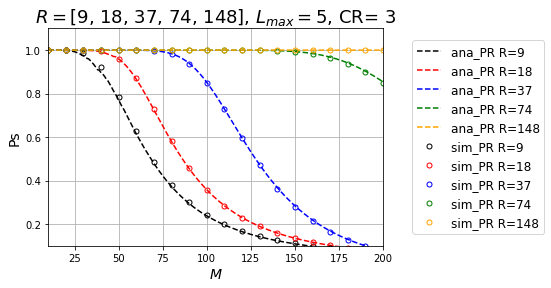

In [167]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

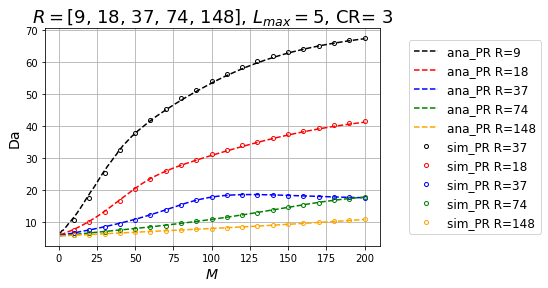

In [168]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

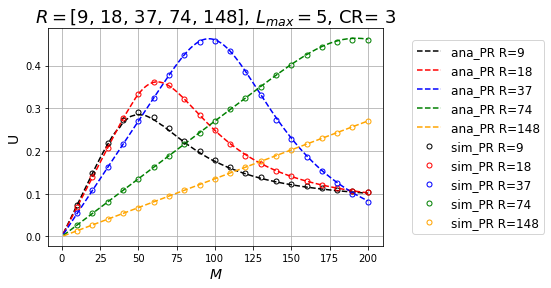

In [169]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

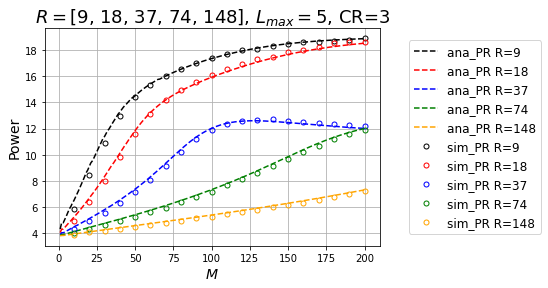

In [170]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=6

In [171]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# # for r in R:
# for idx, r in enumerate(R):
#     for sta in range (1, sta_max+1):
#         Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=float('inf'), step=4)
#         ps_list[idx][sta-1] = Ps
#         da_list[idx][sta-1] = Da
#         u_list[idx][sta-1] = U
        
power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power

In [172]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9985500000000006, 0.9764666666666649, 0.8809749999999996, 0.7202400000000003, 0.5640166666666672, 0.43102857142857004, 0.3339749999999998, 0.26536666666666703, 0.21270999999999934, 0.17779090909090944, 0.1503916666666671, 0.12978461538461583, 0.11470714285714242, 0.09988666666666692, 0.08983750000000001, 0.08202941176470636, 0.07515000000000022, 0.06882105263157878, 0.06379]
da_list_simu_9 = [11.319336900000032, 19.094183400000098, 27.175839591091297, 33.96949986716942, 39.12357292593178, 43.13662946261931, 46.471107900628326, 49.58557687260534, 52.311095785142285, 54.793327245304816, 57.189080352821755, 59.3029959218012, 61.03407498907372, 62.40640750315612, 63.73228249018019, 64.84152195870894, 65.90770239793453, 66.77431464951853, 67.3402916337121, 67.98657575086996]
t_list_simu_9 = [0.6666666666666636, 1.331399999999994, 1.9529333333333299, 2.3492666666666713, 2.4008000000000007, 2.2560666666666687, 2.0114666666666694, 1.7811999999999975, 1.592199999999999, 1.4180666666666693, 1.303800000000002, 1.2031333333333367, 1.1248000000000014, 1.0706, 0.9988666666666665, 0.9582666666666646, 0.9296666666666664, 0.9017999999999982, 0.8717333333333316, 0.8505333333333317]
u_list_simu_9 = [0.074074074074075, 0.14793333333333508, 0.21699259259259454, 0.2610296296296298, 0.26675555555555547, 0.2506740740740747, 0.2234962962962964, 0.19791111111111137, 0.1769111111111108, 0.15756296296296282, 0.14486666666666656, 0.1336814814814815, 0.12497777777777803, 0.11895555555555566, 0.1109851851851853, 0.10647407407407415, 0.1032962962962965, 0.10019999999999989, 0.09685925925925928, 0.09450370370370374]
power_list_simu_9 = [6.251600000000003, 8.90548947368421, 11.459967111630387, 13.369699271164311, 14.680876164028485, 15.53771828291493, 16.21309293666672, 16.798576288335415, 17.234894231030868, 17.545240488861005, 17.860163723158458, 18.127409160373492, 18.283576012975708, 18.411700723932427, 18.4985750848741, 18.623256648394793, 18.74474305861062, 18.82315212592274, 18.812552129458073, 18.83330779066567]


ps_list_simu_18 = [1.0, 1.0, 0.9990333333333332, 0.9846750000000042, 0.9270800000000035, 0.8031833333333341, 0.6459714285714291, 0.5102500000000004, 0.39464444444444285, 0.3094000000000006, 0.24678181818181838, 0.20082499999999992, 0.1658384615384623, 0.1387357142857145, 0.11886000000000037, 0.10373749999999986, 0.09098823529411808, 0.0812722222222224, 0.07307894736842104, 0.06668500000000001]
da_list_simu_18 = [7.752154500000026, 10.52426595000004, 14.100024454187178, 18.08721801714209, 21.736252864258503, 24.52543009881495, 26.674638651443043, 28.574509707902873, 30.16375445579854, 31.723110230780804, 33.13411703711585, 34.494202005341094, 35.735645754317716, 36.925684923433614, 38.02819855149136, 38.962635548650596, 39.84668834937474, 40.626497460881275, 41.20912638164321, 41.73744778458196]
t_list_simu_18 = [1.25, 2.5, 3.746375, 4.923375, 5.79425, 6.023875, 5.65225, 5.1025, 4.43975, 3.8675, 3.39325, 3.012375, 2.694875, 2.427875, 2.228625, 2.07475, 1.9335, 1.828625, 1.735625, 1.667125]
u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.20813194444444685, 0.27352083333333094, 0.32190277777777865, 0.33465972222222257, 0.31401388888888865, 0.2834722222222222, 0.2466527777777776, 0.21486111111111106, 0.18851388888888912, 0.16735416666666655, 0.14971527777777793, 0.13488194444444432, 0.12381250000000013, 0.11526388888888896, 0.10741666666666691, 0.10159027777777778, 0.09642361111111115, 0.0926180555555555]
power_list_simu_18 = [5.054900000000001, 6.623199999999993, 8.467309031198681, 10.427399995173227, 12.203017395959405, 13.505716563340826, 14.378525214357381, 15.157406669952982, 15.719814031961905, 16.245263102417496, 16.67458068303706, 16.983258566457085, 17.314228649802214, 17.646347446196643, 17.888915386857697, 18.152006884655925, 18.473062532366576, 18.433209476256923, 18.59095129635165, 18.61715040443583]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 0.9996800000000003, 0.9978333333333337, 0.9873714285714269, 0.9494750000000006, 0.8671444444444457, 0.7485200000000002, 0.6152727272727264, 0.4898916666666671, 0.3787461538461525, 0.29468571428571483, 0.22629333333333315, 0.1736437500000003, 0.1331764705882357, 0.10316666666666666, 0.07748421052631568, 0.060325]
da_list_simu_37 = [6.66123660000001, 7.687198650000028, 8.832861000000012, 10.077091725000058, 11.475164465561228, 13.108622166140345, 14.798504936191279, 16.33401366711337, 17.432952655294436, 18.090201679292687, 18.392385648953077, 18.476939335362477, 18.404154397247055, 18.238445646405975, 18.18152938523431, 17.943322833540027, 17.858184932056073, 17.72797441144344, 17.61158246091412, 17.585673699060653]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 9.996800000000002, 11.974000000000009, 13.823200000000012, 15.19160000000001, 15.608599999999985, 14.970400000000007, 13.535999999999998, 11.757400000000011, 9.847400000000006, 8.251200000000003, 6.788800000000006, 5.556600000000009, 4.528000000000004, 3.714000000000001, 2.9443999999999986, 2.4130000000000003]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27018378378377944, 0.32362162162162045, 0.3736000000000011, 0.4105837837837849, 0.4218540540540525, 0.404605405405405, 0.36583783783783735, 0.3177675675675677, 0.2661459459459459, 0.22300540540540528, 0.18348108108108094, 0.15017837837837844, 0.12237837837837832, 0.10037837837837822, 0.0795783783783782, 0.06521621621621652]
power_list_simu_37 = [4.4133, 5.0711999999999975, 5.844266666666669, 6.682949999999999, 7.558857755102031, 8.675962389352984, 9.806501908496225, 10.842579334927933, 11.61723431687279, 12.141469635919043, 12.432367395715916, 12.50563015348014, 12.591194632667701, 12.524368109039278, 12.479367315121026, 12.37086932856076, 12.35480374185923, 12.249149603870123, 12.238607548623511, 12.270005934154426]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 0.9999555555555555, 0.9997900000000002, 0.9994545454545457, 0.9983416666666677, 0.994776923076922, 0.9876285714285665, 0.9727600000000087, 0.9474562499999988, 0.9165294117647035, 0.8682111111111116, 0.8118842105263133, 0.7480150000000004]
da_list_simu_74 = [6.1359167999999515, 6.675419100000022, 7.205655499999998, 7.766195175000038, 8.306973900000008, 8.92173800000001, 9.483716185714279, 10.126555921153917, 10.80927327528942, 11.551002029392421, 12.318994779752208, 13.170462502588059, 14.008650156322686, 14.783039701771617, 15.645947328831026, 16.37197303180541, 16.917432568163377, 17.406537429466553, 17.81430898656752, 18.074160129279225]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 17.999200000000002, 19.995800000000003, 21.98799999999999, 23.96019999999997, 25.864199999999947, 27.653599999999923, 29.182799999999965, 30.31859999999996, 31.16200000000003, 31.255600000000005, 30.851600000000023, 29.920600000000043]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.2162108108108128, 0.2432324324324381, 0.27021351351350914, 0.2971351351351306, 0.3237864864864853, 0.34951621621621864, 0.3736972972972973, 0.39436216216216236, 0.4097108108108106, 0.42110810810810806, 0.42237297297297255, 0.41691351351351325, 0.40433243243243233]
power_list_simu_74 = [4.067199999999999, 4.430399999999999, 4.773233333333342, 5.169150000000004, 5.486060000000002, 5.894966666666664, 6.273657142857138, 6.709235576923081, 7.1456589859266755, 7.624133412113989, 8.14205538141387, 8.69847055358492, 9.270323910463937, 9.795338115556854, 10.361692871043157, 10.89045359611943, 11.264064782265013, 11.601403489682525, 11.907677725129286, 12.15459599769117]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999777777777777, 0.9999315789473685, 0.9998700000000001]
da_list_simu_148 = [5.901054599999905, 6.206261999999984, 6.450011899999998, 6.705344175000019, 6.961678680000005, 7.21492140000001, 7.486739142857152, 7.753218187500042, 8.019100666666676, 8.288706839999985, 8.5898503090909, 8.866899000000005, 9.197984007692307, 9.490118571428583, 9.82332898, 10.161123037500042, 10.49625134117644, 10.823548570786516, 11.204998799584077, 11.56384306454367]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.999199999999995, 37.99739999999999, 39.99479999999999]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.2432378378378435, 0.2567391891891832, 0.27023513513513076]
power_list_simu_148 = [3.8946999999999963, 4.114349999999993, 4.264500000000002, 4.427799999999997, 4.606819999999993, 4.756783333333331, 4.951014285714287, 5.122512499999998, 5.298666666666666, 5.4844700000000035, 5.6730272727272695, 5.8560333333333325, 6.08570769230769, 6.271878571428574, 6.512459999999997, 6.712125000000006, 6.934905882352944, 7.140334644194748, 7.411381416010473, 7.6643346881697685]

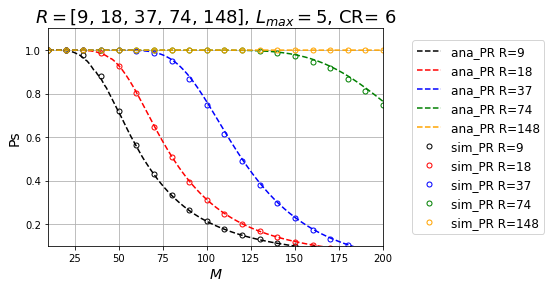

In [173]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

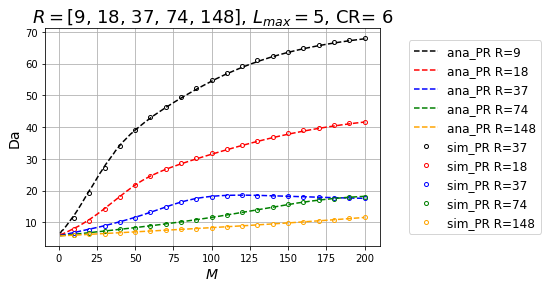

In [174]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

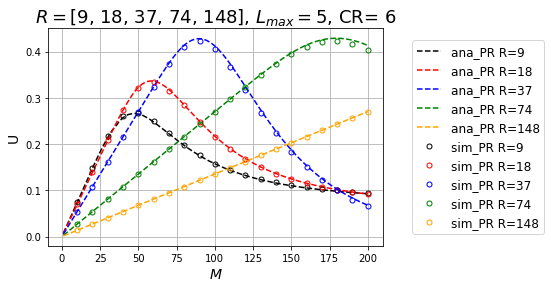

In [175]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

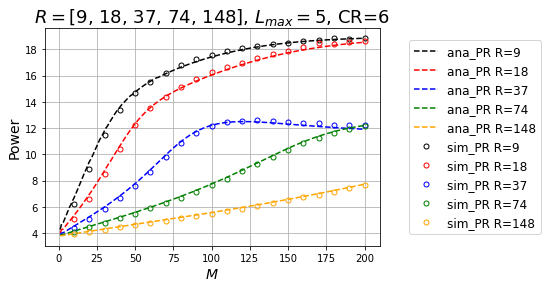

In [176]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()